In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.io import make_dataloader, collate_fn_basic

from stack_segmentation.training import (
    handle_stacks_data, 
    make_optimization_task, 
    train_loop
)

from stack_segmentation.pipeline_config import (
    dataloaders_conf,
    train_conf,
    model_config, 
    aug_config,
    optimizer_config,
    loss_config,
    scheduler_config,
)

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
train_conf['device'] = 'cuda:1'
# train_conf['device'] = 'cpu'
train_conf['num_epochs'] = 500
train_conf

{'num_epochs': 500, 'device': 'cuda:1'}

In [8]:
data_conf['conf_name'] = 'exp_basic_adamw_lr5e-3_epoch_300_resnet50_encoder_soft_aug_k_1_weight10_patch64_bs_32'
data_conf['patches'] = {
    'train': (64, 64, 1),
    'val': (64, 64, 1),
    'test': (64, 64, 1)
}
data_conf

{'conf_name': 'exp_basic_adamw_lr5e-3_epoch_300_resnet50_encoder_soft_aug_k_1_weight10_patch64_bs_32',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_t

In [9]:
model_config

{'source': 'qubvel',
 'model_type': 'Unet',
 'encoder_name': 'resnet50',
 'encoder_weights': 'imagenet'}

In [10]:
optimizer_config['opt_type'] = 'AdamW'
optimizer_config['lr'] = 5e-3
optimizer_config['weight_decay'] = 5e-5
optimizer_config['amsgrad'] = True
# optimizer_config['nesterov'] = True
optimizer_config

{'opt_type': 'AdamW',
 'lr': 0.005,
 'weight_decay': 5e-05,
 'amsgrad': True,
 'nesterov': False,
 'momentum': 0.9,
 'centered': False}

In [11]:
aug_config['aug_type'] = 'soft'
aug_config['k'] = 1
aug_config['original_height'] = 64
aug_config['original_width'] = 64
aug_config

{'aug_type': 'soft', 'original_height': 64, 'original_width': 64, 'k': 1}

In [12]:
loss_config =[
    {
        'loss': 'BCE', 
        'weight': 1, 
        'params': {'weight': [1, 10]}},
    {
        'loss': 'Dice',
        'weight': 2, 
        'params': {
            'mode': 'multiclass',
            'classes': [1], # может быть, этот параметр не нужен
            'log_loss': True,
            'from_logits': True,
            'smooth': 1,
            'eps': 1e-7
        }
    }
]
loss_config

[{'loss': 'BCE', 'weight': 1, 'params': {'weight': [1, 10]}},
 {'loss': 'Dice',
  'weight': 2,
  'params': {'mode': 'multiclass',
   'classes': [1],
   'log_loss': True,
   'from_logits': True,
   'smooth': 1,
   'eps': 1e-07}}]

In [13]:
dataloaders_conf['train']['batch_size'] = 32
dataloaders_conf['val']['batch_size'] = 32
dataloaders_conf['test']['batch_size'] = 32
dataloaders_conf

{'train': {'batch_size': 32, 'num_workers': 16, 'shuffle': True},
 'val': {'batch_size': 32, 'num_workers': 16, 'shuffle': False},
 'test': {'batch_size': 32, 'num_workers': 16, 'shuffle': True}}

## Prepare train, validation and test data

In [14]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:01, 670.87it/s]
100%|██████████| 720/720 [00:07<00:00, 94.03it/s] 
33120it [00:00, 244802.44it/s]
31680it [00:00, 153363.54it/s]
700it [00:00, 848.51it/s]
100%|██████████| 700/700 [00:06<00:00, 101.90it/s]
27830it [00:00, 138645.87it/s]
26620it [00:00, 228601.44it/s]
710it [00:00, 857.08it/s]
100%|██████████| 710/710 [00:07<00:00, 96.45it/s] 
31680it [00:00, 139883.87it/s]
30240it [00:00, 126147.37it/s]
720it [00:00, 848.80it/s]
100%|██████████| 720/720 [00:07<00:00, 95.50it/s] 
33120it [00:00, 249030.34it/s]
720it [00:00, 831.04it/s]
100%|██████████| 720/720 [00:07<00:00, 95.33it/s] 
103680it [00:00, 174097.99it/s]
700it [00:00, 728.37it/s]
100%|██████████| 700/700 [00:06<00:00, 103.38it/s]
84700it [00:00, 225405.07it/s]
509it [00:00, 1197.05it/s]
100%|██████████| 509/509 [00:02<00:00, 196.69it/s]
32576it [00:00, 93549.77it/s]
700it [00:00, 870.04it/s]
100%|██████████| 700/700 [00:06<00:00, 101.16it/s]
84700it [00:00, 222173.99it/s]
700it [00:00, 838.19it/s]
100%|██████████|

In [15]:
len(data_train), len(data_val), len(data_test)

(92630, 88540, 11)

In [16]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    aug_config=aug_config,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        model_config=model_config,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [17]:
device = 'cuda:1'
# device = 'cpu'

In [18]:
model, criterion, optimizer, scheduler = make_optimization_task(
    device,
    model_config=model_config,
    loss_config=loss_config, 
    optimizer_config=optimizer_config,
    scheduler_config=scheduler_config)

## Run experiment

In [19]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [20]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [21]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    es_patience=20,
    **train_conf)

  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 0...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.052145


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.030857
Epoch 1...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.030402


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.036341
EarlyStopping counter: 1 out of 20
Epoch 2...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.02751


100%|██████████| 2767/2767 [00:53<00:00, 52.08it/s]


Mean val loss: 0.026575


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 3...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.026524


100%|██████████| 2767/2767 [00:53<00:00, 51.83it/s]


Mean val loss: 0.025894


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 4...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.025641


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.026862
EarlyStopping counter: 1 out of 20
Epoch 5...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.025023


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.026016
EarlyStopping counter: 2 out of 20
Epoch 6...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.024918


100%|██████████| 2767/2767 [00:53<00:00, 51.81it/s]


Mean val loss: 0.024217


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 7...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.024436


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.025388
EarlyStopping counter: 1 out of 20
Epoch 8...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.023957


100%|██████████| 2767/2767 [00:53<00:00, 51.87it/s]


Mean val loss: 0.023522


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 9...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.023557


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.023563
EarlyStopping counter: 1 out of 20
Epoch 10...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.023355


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.023805
EarlyStopping counter: 2 out of 20
Epoch 11...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.023191


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.031207
EarlyStopping counter: 3 out of 20
Epoch 12...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022753


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.027485
EarlyStopping counter: 5 out of 20
Epoch 14...


 83%|████████▎ | 2407/2895 [02:38<00:30, 15.96it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022173


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.034251
EarlyStopping counter: 10 out of 20
Epoch 19...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022069


 39%|███▉      | 1091/2767 [00:21<00:34, 48.96it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022011


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.026543
EarlyStopping counter: 16 out of 20
Epoch 25...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022252


 13%|█▎        | 358/2767 [00:07<00:47, 51.10it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021594


100%|██████████| 2767/2767 [00:53<00:00, 51.85it/s]


Mean val loss: 0.022044


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 31...


 90%|█████████ | 2611/2895 [02:50<00:18, 15.22it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021809


100%|██████████| 2767/2767 [00:53<00:00, 51.94it/s]


Mean val loss: 0.021999


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 36...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021552


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022559
EarlyStopping counter: 1 out of 20
Epoch 37...


  3%|▎         | 97/2895 [00:07<02:57, 15.79it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021272


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022717
EarlyStopping counter: 3 out of 20
Epoch 42...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021189


 67%|██████▋   | 1841/2767 [00:35<00:18, 50.25it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.02115


100%|██████████| 2767/2767 [00:53<00:00, 51.56it/s]


Mean val loss: 0.021278


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 48...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020984


 17%|█▋        | 479/2767 [00:10<00:42, 53.81it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021467


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021522
EarlyStopping counter: 6 out of 20
Epoch 54...


 81%|████████  | 2347/2895 [02:34<00:35, 15.42it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.024131
EarlyStopping counter: 2 out of 20
Epoch 59...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020678


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021183
EarlyStopping counter: 3 out of 20
Epoch 60...


 57%|█████▋    | 1657/2895 [01:48<01:17, 15.91it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020675


100%|██████████| 2767/2767 [00:53<00:00, 51.48it/s]


Mean val loss: 0.020977


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 65...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020652


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021162
EarlyStopping counter: 1 out of 20
Epoch 66...


 36%|███▌      | 1045/2895 [01:09<02:05, 14.79it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020497


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021035
EarlyStopping counter: 6 out of 20
Epoch 71...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020504


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021065
EarlyStopping counter: 7 out of 20
Epoch 72...


 17%|█▋        | 489/2895 [00:33<02:37, 15.23it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020429


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021424
EarlyStopping counter: 1 out of 20
Epoch 77...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020406


 83%|████████▎ | 2286/2767 [00:44<00:09, 52.62it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020381


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021516
EarlyStopping counter: 7 out of 20
Epoch 83...


100%|█████████▉| 2889/2895 [03:11<00:00, 15.90it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021063
EarlyStopping counter: 12 out of 20
Epoch 88...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020316


100%|██████████| 2767/2767 [00:53<00:00, 51.73it/s]


Mean val loss: 0.020811


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 89...


 70%|██████▉   | 2017/2895 [02:12<00:57, 15.18it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020352


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.02142
EarlyStopping counter: 5 out of 20
Epoch 94...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020291


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.020878
EarlyStopping counter: 6 out of 20
Epoch 95...


 45%|████▍     | 1295/2895 [01:26<01:40, 15.87it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020213


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.020651
EarlyStopping counter: 4 out of 20
Epoch 100...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020244


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021324
EarlyStopping counter: 5 out of 20
Epoch 101...


 24%|██▎       | 681/2895 [00:45<02:23, 15.41it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020169


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021111
EarlyStopping counter: 10 out of 20
Epoch 106...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020133


 89%|████████▉ | 2469/2767 [00:47<00:05, 51.30it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020116


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021246
EarlyStopping counter: 16 out of 20
Epoch 112...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020121


 19%|█▉        | 519/2767 [00:10<00:42, 52.38it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020133


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.020905
EarlyStopping counter: 2 out of 20
Epoch 118...


 80%|███████▉  | 2307/2895 [02:31<00:38, 15.17it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.020771
EarlyStopping counter: 7 out of 20
Epoch 123...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020048


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.020716
EarlyStopping counter: 8 out of 20
Epoch 124...


 53%|█████▎    | 1541/2895 [01:42<01:27, 15.45it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022451
EarlyStopping counter: 12 out of 20
Epoch 128...


 65%|██████▍   | 1879/2895 [02:03<01:04, 15.63it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.02001


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.025178
EarlyStopping counter: 14 out of 20
Epoch 130...


 31%|███▏      | 911/2895 [01:01<02:07, 15.52it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.02003


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.023057
EarlyStopping counter: 18 out of 20
Epoch 134...


 41%|████      | 1177/2895 [01:17<01:49, 15.71it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.019997


  0%|          | 0/1035 [00:00<?, ?it/s]

Mean val loss: 0.021626
EarlyStopping counter: 20 out of 20


  9%|▊         | 90/1035 [00:14<02:20,  6.73it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 86%|████████▌ | 871/1018 [02:21<00:23,  6.27it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 18%|█▊        | 467/2647 [01:15<05:35,  6.50it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg

## Dump experiment results

In [22]:
import pickle
import json

In [23]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [28]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [24]:
from itertools import chain

In [25]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [26]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

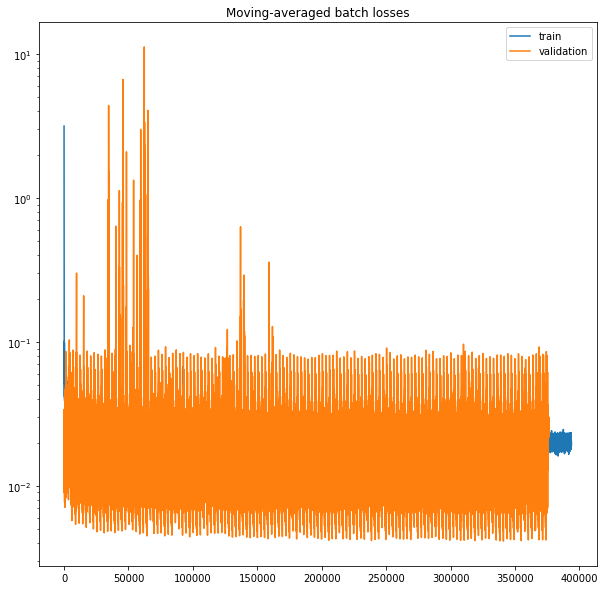

In [27]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [28]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

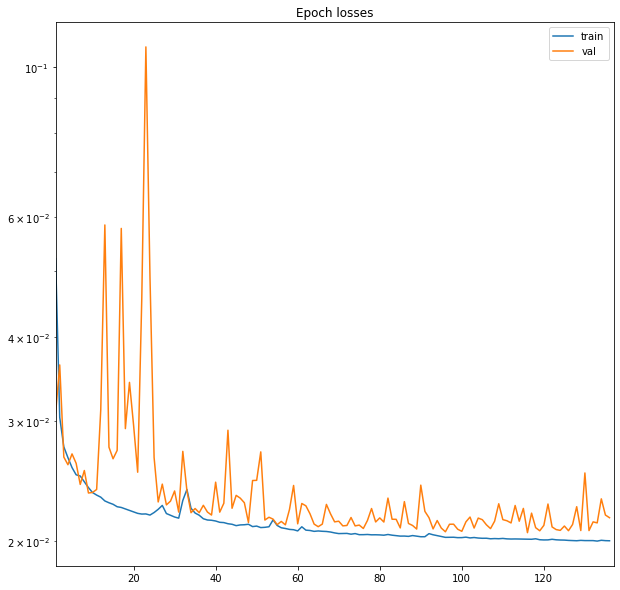

In [29]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [30]:
import pandas as pd

In [31]:
from visualization_utils import make_df

In [32]:
df = make_df(results, model_name='basic')
df

,accuracy,precision,recall,f1,pr_auc,iou,stack,model
0,0.995430,0.937308,0.996853,0.966164,0.997880,0.934543,carb96558,basic
1,0.987671,0.883992,0.997188,0.937184,0.981181,0.881794,carb71,basic
2,0.981820,0.902896,0.936768,0.919520,0.976464,0.851029,carbRNF,basic
3,0.995789,0.991378,0.949084,0.969770,0.997913,0.941314,SPE_carb10_58_box3,basic
4,0.992894,0.961645,0.948953,0.955257,0.994257,0.914346,SoilAh-1,basic
5,0.993443,0.930984,0.995524,0.962173,0.997774,0.927104,SoilB-2,basic
6,0.988503,0.966160,0.940009,0.952905,0.988123,0.910046,TeTree_subset1,basic
7,0.991440,0.968825,0.954635,0.961678,0.991971,0.926184,TiTree_subset2,basic
8,0.992950,0.946139,0.995640,0.970259,0.998162,0.942236,Urna_22,basic
9,0.990128,0.956466,0.986158,0.971085,0.997813,0.943795,Urna_30,basic


In [33]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

Mean   IOU: 0.91422
Std    IOU: 0.030152
Min    IOU: 0.85103
Median IOU: 0.92618


## Check loss to loss ratio

In [40]:
criterion.losses

(WeightedLoss(
   (loss): CrossEntropyLoss()
 ), WeightedLoss(
   (loss): DiceLoss()
 ))

In [35]:
from stack_segmentation.training import make_joint_loss

In [36]:
import torch

In [37]:
# loss_config[0] = {'loss': 'BCE',
#   'weight': 0.5,
#   'params': {}}
# loss_config
# crit = make_joint_loss(device=device, loss_config=loss_config)

In [38]:
crit = criterion
a = []
b = []
for i, (x, y) in enumerate(dataloader_val):
    if i > 100:
        break
    pred = model(torch.from_numpy(x).to(device))
    y = torch.from_numpy(y).to(device)
    a.append(crit.losses[0](pred, y).cpu().data.numpy())
    b.append(crit.losses[1](pred, y).cpu().data.numpy())

In [39]:
print('Mean 0 loss: {:.4f}\nMean 1 loss: {:.4f}\nMean of ratios: {:.4f}\nRatio of means: {:.4f}'
      .format(np.mean(a), np.mean(b), np.mean(np.array(a) / np.array(b)), np.mean(a) / np.mean(b)))

Mean 0 loss: 0.0090
Mean 1 loss: 0.0042
Mean of ratios: 2.5380
Ratio of means: 2.1637
